<a href="https://colab.research.google.com/github/ikfinakmlya/klasifikasi_TBC/blob/main/coba_TBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = "/content/drive/MyDrive/TBC1"


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

train_dir = "/content/drive/MyDrive/TBC1"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,       # 80% train, 20% val
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(64,64),      # resize dari 512x512 ke 64x64
    batch_size=16,
    class_mode="binary",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(64,64),
    batch_size=16,
    class_mode="binary",
    subset="validation"
)

# ✅ Tambahan Step 1: cek mapping kelas
print("class_indices:", train_generator.class_indices)

# ✅ Tambahan Step 2: hitung class weight biar seimbang
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
class_indices: {'Normal': 0, 'Tuberculosis': 1}
Class Weights: {0: np.float64(0.6), 1: np.float64(3.0)}


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Bangun CNN sederhana
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')   # binary output
])

# ✅ Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ✅ Definisikan EarlyStopping
es = EarlyStopping(
    monitor="val_loss",        # pantau val_loss
    patience=5,                # berhenti kalau 5 epoch berturut-turut tidak membaik
    restore_best_weights=True  # balikin ke bobot terbaik
)

# ✅ Training dengan EarlyStopping + class_weight
history = model.fit(
    train_generator,
    epochs=20,                 # lebih besar dari 5
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[es]             # ⬅️ tambahan di sini
)

# ✅ Simpan model
model.save("/content/drive/MyDrive/cnn_tbc_model.keras")


Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 51s 238ms/step - accuracy: 0.6639 - loss: 0.6697 - val_accuracy: 0.8155 - val_loss: 0.4406
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 50s 238ms/step - accuracy: 0.8745 - loss: 0.3355 - val_accuracy: 0.9048 - val_loss: 0.2389
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 50s 240ms/step - accuracy: 0.9028 - loss: 0.2592 - val_accuracy: 0.9226 - val_loss: 0.2064
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 50s 238ms/step - accuracy: 0.9083 - loss: 0.2498 - val_accuracy: 0.9048 - val_loss: 0.2435
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 50s 238ms/step - accuracy: 0.9185 - loss: 0.2217 - val_accuracy: 0.9310 - val_loss: 0.1752
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 50s 236ms/step - accuracy: 0.9224 - loss: 0.2147 - val_accuracy: 0.9060 - val_loss: 0.2262
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 50s 236ms/step - accuracy: 0.9268 - loss: 0.2271 - val_accuracy: 0.9429 - val_loss: 0.1735
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 51s 242ms/step - accuracy: 0.9407 - loss: 0

In [8]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_with_prob(model, img_path, target_size=(64,64)):
    img = image.load_img(img_path, target_size=target_size)
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, 0)
    prob = float(model.predict(arr)[0][0])
    return prob

# 🔹 Contoh pemakaian
img_path = "/content/drive/MyDrive/TBC1/Normal/Normal-1.png"   # ganti sesuai path gambar
prob = predict_with_prob(model, img_path)

print("Prob(TBC) =", prob)
if prob > 0.5:
    print("Prediksi: TBC")
else:
    print("Prediksi: Normal")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Prob(TBC) = 0.0009012023801915348
Prediksi: Normal


53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.9539 - loss: 0.1175
Validation Loss: 0.11265087127685547
Validation Accuracy: 0.9607142806053162
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step


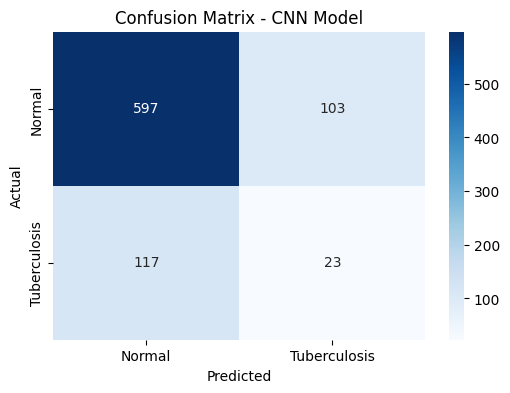

Classification Report:
              precision    recall  f1-score   support

      Normal       0.84      0.85      0.84       700
Tuberculosis       0.18      0.16      0.17       140

    accuracy                           0.74       840
   macro avg       0.51      0.51      0.51       840
weighted avg       0.73      0.74      0.73       840



In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Evaluasi akurasi dan loss di validation set
val_loss, val_acc = model.evaluate(val_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# 2. Prediksi probabilitas pada data validasi
y_proba = model.predict(val_generator)

# 3. Ubah ke kelas (0/1)
y_pred = (y_proba > 0.5).astype("int32").reshape(-1)

# 4. Label sebenarnya
y_true = val_generator.classes

# 5. Ambil nama kelas otomatis dari generator
target_names = list(val_generator.class_indices.keys())

# 6. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN Model")
plt.show()

# 7. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))
